In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/clean_data.csv",low_memory=False)

In [3]:
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
0                       0.0          0         4593  ...   
1                       0.0          0         1820  ...   
2                       0.0          0         2348  ...   
3                       0.0          0         1819  ...   
4                       0.0          0         2119  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                                True                     True   
3                                True                     True   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2              True                        True                     True   
3              True                        True                     True   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                        False                  False   
1                         True                   True   
2                        False                  False   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                       False                          True   
1                        True                         False   
2                       False                          True   
3                        True                         False   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                         False  
4                          True  

[5 rows x 103 columns]

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

Wall time: 2min 53s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875468079970562

### This metric is not acceptable because it is tested on the same data , it is trained on

### Splitting data into train/validation sets

In [10]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [12]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [13]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [14]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

## Splitting the data based on the year, according to Kaggle instruction

In [15]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

## Building an evaluation function

In [16]:
# Create evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
   
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [17]:
len(X_train)

401125

In [18]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [19]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

Wall time: 8.46 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [20]:
(X_train.shape[0] * 100) / 1000000

40.1125

In [21]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

## Hyerparameter tuning with RandomizedSearchCV

In [22]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 59.2 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [23]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

## Train a model with the best hyperparamters

In [24]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 35.1 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [25]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [26]:
show_scores(rs_model)

{'Training MAE': 5869.318190328771,
 'Valid MAE': 7408.797910226009,
 'Training RMSLE': 0.268183819543819,
 'Valid RMSLE': 0.30027374112644867,
 'Training R^2': 0.8447703182321143,
 'Valid R^2': 0.8194751352222651}

## Make predictions on test data

In [27]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc  ...  \
0                    3688.0       Low 2012-05-03        580G  ...   
1                   28555.0      High 2012-05-10         936  ...   
2                    6038.0    Medium 2012-05-10    EC210BLC  ...   
3                    8940.0      High 2012-05-10       330CL  ...   
4                    2286.0       Low 2012-05-10        650K  ...   

  Undercarriage_Pad_Width         Stick_Length   Thumb      Pattern_Changer  \
0                     NaN                  NaN     NaN                  NaN   
1                     NaN                  NaN     NaN                  NaN   
2     None or Unspecified                9' 6"  Manual  None or Unspecified   
3     None or Unspecified  None or Unspecified  Manual                  Yes   
4                     NaN                  NaN     NaN                  NaN   

  Grouser_Type     Backhoe_Mounting Blade_Type      Travel_Controls  \
0          NaN                  NaN        NaN                  NaN   
1          NaN                  NaN        NaN                  NaN   
2       Double                  NaN        NaN                  NaN   
3       Triple                  NaN        NaN                  NaN   
4          NaN  None or Unspecified        PAT  None or Unspecified   

  Differential_Type Steering_Controls  
0               NaN               NaN  
1          Standard      Conventional  
2               NaN               NaN  
3               NaN               NaN  
4               NaN               NaN  

[5 rows x 52 columns]


## Getting the test dataset in the same format as our training dataset

In [28]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [29]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                    3688.0          2          499          180  ...   
1                   28555.0          1          831          292  ...   
2                    6038.0          3         1177          404  ...   
3                    8940.0          1          287          113  ...   
4                    2286.0          2          566          196  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                               False                    False   
3                               False                    False   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2             False                       False                    False   
3             False                       False                    False   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                         True                   True   
1                         True                   True   
2                         True                   True   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                        True                          True   
1                        True                         False   
2                        True                          True   
3                        True                          True   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                          True  
4                          True  

[5 rows x 101 columns]

In [30]:
X_train.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770    1126363     8434         132          18.0      1974   
1  1821514    1194089    10150         132          99.0      1980   
2  1505138    1473654     4139         132          99.0      1978   
3  1671174    1327630     8591         132          99.0      1980   
4  1329056    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                       0.0          0         4593         1744  ...   
1                       0.0          0         1820          559  ...   
2                       0.0          0         2348          713  ...   
3                       0.0          0         1819          558  ...   
4                       0.0          0         2119          683  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                                True                     True   
3                                True                     True   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2              True                        True                     True   
3              True                        True                     True   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                        False                  False   
1                         True                   True   
2                        False                  False   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                       False                          True   
1                        True                         False   
2                       False                          True   
3                        True                         False   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                         False  
4                          True  

[5 rows x 102 columns]

In [31]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [32]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                    3688.0          2          499          180  ...   
1                   28555.0          1          831          292  ...   
2                    6038.0          3         1177          404  ...   
3                    8940.0          1          287          113  ...   
4                    2286.0          2          566          196  ...   

   Stick_Length_is_missing  Thumb_is_missing  Pattern_Changer_is_missing  \
0                     True              True                        True   
1                     True              True                        True   
2                    False             False                       False   
3                    False             False                       False   
4                     True              True                        True   

   Grouser_Type_is_missing  Backhoe_Mounting_is_missing  \
0                     True                         True   
1                     True                         True   
2                    False                         True   
3                    False                         True   
4                     True                        False   

   Blade_Type_is_missing  Travel_Controls_is_missing  \
0                   True                        True   
1                   True                        True   
2                   True                        True   
3                   True                        True   
4                  False                       False   

   Differential_Type_is_missing  Steering_Controls_is_missing  \
0                          True                          True   
1                         False                         False   
2                          True                          True   
3                          True                          True   
4                          True                          True   

   auctioneerID_is_missing  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  

[5 rows x 102 columns]

In [35]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

C:\Users\abrar\Desktop\bulldozer_price_prediction_project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [36]:
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

In [37]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

SalesID    SalesPrice
0      1227829  20614.367809
1      1227844  19897.801707
2      1227847  44852.219594
3      1227848  68346.325323
4      1227863  39487.349708
...        ...           ...
12452  6643171  46466.092910
12453  6643173  17500.493352
12454  6643184  14296.986205
12455  6643186  22164.857577
12456  6643196  31683.800634

[12457 rows x 2 columns]

In [38]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

In [39]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [43]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

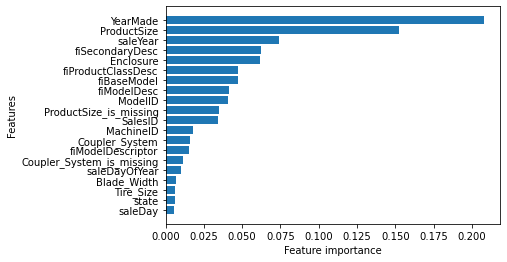

In [44]:
plot_features(X_train.columns, ideal_model.feature_importances_)